In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

! pip install optuna
import statsmodels.api as sm
import statsmodels
import lightgbm as lgb

main_directory = Path.cwd().parent.as_posix()

You should consider upgrading via the '/home/tymo/Desktop/ZooplaScrape/datascience/bin/python3 -m pip install --upgrade pip' command.


In [2]:
df = pd.read_csv(f"{main_directory}/databases/zoopla_data.csv")
#df = pd.get_dummies(df, columns = ['type'], drop_first = True, prefix = 'type')
#df = pd.get_dummies(df, columns = ['location'], drop_first = True, prefix = 'location')
df

,type,price,station,beds,baths,receptions,post_code,location,avg_sold_price_12months,avg_type
0,flat,110000.0,1.3,2,1.0,1.0,M8,manchester,162788,101576.0
1,flat,115000.0,1.4,2,1.0,1.0,M8,manchester,162788,101576.0
2,flat,170000.0,0.7,2,1.0,1.0,M8,manchester,162788,101576.0
3,semi-detached,180000.0,1.4,3,1.0,1.0,M8,manchester,162788,208116.0
4,semi-detached,190000.0,1.9,3,1.0,0.0,M8,manchester,162788,208116.0
...,...,...,...,...,...,...,...,...,...,...
6134,detached,600000.0,4.1,4,0.0,0.0,CA4,cumbria,272071,334295.0
6135,detached,375000.0,1.7,4,1.0,1.0,CA4,carlisle,272071,334295.0
6136,detached,447500.0,0.4,4,0.0,0.0,CA4,carlisle,272071,334295.0
6137,detached,350000.0,1.4,5,0.0,0.0,CA4,carlisle,272071,334295.0


In [3]:
"""categorical_columns = ['type']
category_ids = [df.columns.get_loc(col) for col in categorical_columns]
category_ids

for column in categorical_columns:
    df[column] = pd.Categorical(df[column])
    """

"categorical_columns = ['type']\ncategory_ids = [df.columns.get_loc(col) for col in categorical_columns]\ncategory_ids\n\nfor column in categorical_columns:\n    df[column] = pd.Categorical(df[column])\n    "

In [4]:
X = df.drop(['price','location','post_code','type'],axis=1)
y = df.price

In [5]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [6]:
import time
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

N_SPLITS = 10
strat_kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

scores = np.empty(N_SPLITS)
for idx, (train_idx, test_idx) in enumerate(strat_kf.split(X, y)):
    print("=" * 16 + f"Training fold {idx}" + 16 * "=")
    start = time.time()

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    eval_set = [(X_test, y_test)]

    lgbm_reg = lgb.LGBMRegressor(n_estimators=1000)
    lgbm_reg.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        #categorical_feature=category_ids,
        callbacks=[lgb.early_stopping(100),lgb.log_evaluation(10)],
        eval_metric="rmse",
    )

    preds = lgbm_reg.predict(X_test)
    loss = MSE(y_test, preds,squared=False)
    scores[idx] = loss
    runtime = time.time() - start
    print(f"Fold {idx} finished with score: {loss:.5f} in {runtime:.2f} seconds.\n")




/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


================Training fold 0================
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 137670	valid_0's l2: 1.89531e+10
[20]	valid_0's rmse: 123866	valid_0's l2: 1.53427e+10
[30]	valid_0's rmse: 120273	valid_0's l2: 1.44656e+10
[40]	valid_0's rmse: 119349	valid_0's l2: 1.42441e+10
[50]	valid_0's rmse: 118469	valid_0's l2: 1.40349e+10
[60]	valid_0's rmse: 118418	valid_0's l2: 1.40229e+10
[70]	valid_0's rmse: 118319	valid_0's l2: 1.39993e+10
[80]	valid_0's rmse: 117753	valid_0's l2: 1.38657e+10
[90]	valid_0's rmse: 117842	valid_0's l2: 1.38867e+10
[100]	valid_0's rmse: 117972	valid_0's l2: 1.39175e+10
[110]	valid_0's rmse: 118166	valid_0's l2: 1.39631e+10
[120]	valid_0's rmse: 117993	valid_0's l2: 1.39224e+10
[130]	valid_0's rmse: 118201	valid_0's l2: 1.39714e+10
[140]	valid_0's rmse: 118088	valid_0's l2: 1.39449e+10
[150]	valid_0's rmse: 118261	valid_0's l2: 1.39858e+10
[160]	valid_0's rmse: 118091	valid_0's l2: 1.39456e+10
[170]	valid_0's rms

In [18]:
import optuna  # pip install optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

def objective(trial, X, y):
    param_grid = {
    # "device_type": trial.suggest_categorical("device_type", ['gpu']),
    "n_estimators": trial.suggest_int("n_estimators", 200,1250),
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
    "num_leaves": trial.suggest_int("num_leaves", 20, 750, step=20),
    "max_depth": trial.suggest_int("max_depth", 1, 6),
    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 150, step=5),
    "lambda_l1": trial.suggest_int("lambda_l1", 0, 200, step=5),
    "lambda_l2": trial.suggest_int("lambda_l2", 0, 200, step=5),
    "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
    "bagging_fraction": trial.suggest_float(
        "bagging_fraction", 0.2, 0.8, step=0.05
    ),
    "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
    "feature_fraction": trial.suggest_float(
        "feature_fraction", 0.2, 0.8, step=0.05
    ),
    }

    splits = 10
    cv = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)

    cv_scores = np.empty(splits)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgb.LGBMRegressor(**param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="rmse",
            callbacks=[lgb.early_stopping(20)]
        )
        preds = model.predict(X_test)
        
        cv_scores[idx] = MAPE(y_test, preds)

    return np.mean(cv_scores)



In [8]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

[I 2022-01-12 17:58:38,506] A new study created in memory with name: LGBM Classifier
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=11.893775930369458, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.893775930369458
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[274]	valid_0's rmse: 130651	valid_0's l2: 1.70697e+10
[Light

[I 2022-01-12 17:58:40,979] Trial 0 finished with value: 0.22732853968361882 and parameters: {'n_estimators': 274, 'learning_rate': 0.05389301257023863, 'num_leaves': 560, 'max_depth': 3, 'min_data_in_leaf': 60, 'lambda_l1': 95, 'lambda_l2': 75, 'min_gain_to_split': 11.893775930369458, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 0 with value: 0.22732853968361882.


Did not meet early stopping. Best iteration is:
[272]	valid_0's rmse: 90525.2	valid_0's l2: 8.19482e+09
[LightGBM] [Warning] lambda_l1 is set=145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=145
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] min_gain_to_split is set=13.062226573655375, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.062226573655375
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scor

/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Did not meet early stopping. Best iteration is:
[364]	valid_0's rmse: 133734	valid_0's l2: 1.78849e+10
[LightGBM] [Warning] lambda_l1 is set=145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=145
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] min_gain_to_split is set=13.062226573655375, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.062226573655375
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation score

[I 2022-01-12 17:58:43,512] Trial 1 finished with value: 0.2489455053073369 and parameters: {'n_estimators': 364, 'learning_rate': 0.028388955031396546, 'num_leaves': 700, 'max_depth': 1, 'min_data_in_leaf': 100, 'lambda_l1': 145, 'lambda_l2': 20, 'min_gain_to_split': 13.062226573655375, 'bagging_fraction': 0.65, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.22732853968361882.


Did not meet early stopping. Best iteration is:
[364]	valid_0's rmse: 90838.6	valid_0's l2: 8.25166e+09
[LightGBM] [Warning] lambda_l1 is set=150, reg_alpha=0.0 will be ignored. Current value: lambda_l1=150
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=13.804695292060853, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.804695292060853
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Ear

/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Early stopping, best iteration is:
[85]	valid_0's rmse: 105914	valid_0's l2: 1.12178e+10
[LightGBM] [Warning] lambda_l1 is set=150, reg_alpha=0.0 will be ignored. Current value: lambda_l1=150
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=13.804695292060853, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.804695292060853
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping, be

[I 2022-01-12 17:58:45,022] Trial 2 finished with value: 0.22094918056936025 and parameters: {'n_estimators': 445, 'learning_rate': 0.29419090898387834, 'num_leaves': 380, 'max_depth': 4, 'min_data_in_leaf': 20, 'lambda_l1': 150, 'lambda_l2': 55, 'min_gain_to_split': 13.804695292060853, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.25}. Best is trial 2 with value: 0.22094918056936025.


Early stopping, best iteration is:
[82]	valid_0's rmse: 90461.6	valid_0's l2: 8.1833e+09
[LightGBM] [Warning] lambda_l1 is set=150, reg_alpha=0.0 will be ignored. Current value: lambda_l1=150
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=13.804695292060853, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.804695292060853
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping, be

/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Early stopping, best iteration is:
[343]	valid_0's rmse: 132515	valid_0's l2: 1.75601e+10
[LightGBM] [Warning] lambda_l1 is set=135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=135
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_gain_to_split is set=10.154918291141522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.154918291141522
[LightGBM] [Warning] lambda_l2 is set=135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=135
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stoppin

[I 2022-01-12 17:58:46,984] Trial 3 finished with value: 0.23647784310131562 and parameters: {'n_estimators': 1075, 'learning_rate': 0.11147696676959014, 'num_leaves': 680, 'max_depth': 1, 'min_data_in_leaf': 80, 'lambda_l1': 135, 'lambda_l2': 135, 'min_gain_to_split': 10.154918291141522, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.55}. Best is trial 2 with value: 0.22094918056936025.


Early stopping, best iteration is:
[329]	valid_0's rmse: 95540	valid_0's l2: 9.12789e+09
[LightGBM] [Warning] lambda_l1 is set=135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=135
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_gain_to_split is set=10.154918291141522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.154918291141522
[LightGBM] [Warning] lambda_l2 is set=135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=135
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping

/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.45, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45
[LightGBM] [Warning] min_gain_to_split is set=2.090649199539341, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.090649199539341
[LightGBM] [Warning] lambda_l2 is set=110, reg_lambda=0.0 will be ignored. Current value: lambda_l2=110
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[338]	valid_0's rmse: 13276

[I 2022-01-12 17:58:52,084] Trial 4 finished with value: 0.23465860659281929 and parameters: {'n_estimators': 340, 'learning_rate': 0.04612846968036937, 'num_leaves': 360, 'max_depth': 4, 'min_data_in_leaf': 140, 'lambda_l1': 75, 'lambda_l2': 110, 'min_gain_to_split': 2.090649199539341, 'bagging_fraction': 0.45, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 2 with value: 0.22094918056936025.


Did not meet early stopping. Best iteration is:
[340]	valid_0's rmse: 93605.1	valid_0's l2: 8.76191e+09
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] min_gain_to_split is set=6.35498754079104, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.35498754079104
[LightGBM] [Warning] lambda_l2 is set=175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=175
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds


/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Early stopping, best iteration is:
[577]	valid_0's rmse: 125101	valid_0's l2: 1.56503e+10
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] min_gain_to_split is set=6.35498754079104, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.35498754079104
[LightGBM] [Warning] lambda_l2 is set=175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=175
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping, bes

[I 2022-01-12 17:59:01,269] Trial 5 finished with value: 0.2146423149157771 and parameters: {'n_estimators': 606, 'learning_rate': 0.0387499721454181, 'num_leaves': 740, 'max_depth': 5, 'min_data_in_leaf': 110, 'lambda_l1': 0, 'lambda_l2': 175, 'min_gain_to_split': 6.35498754079104, 'bagging_fraction': 0.65, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 5 with value: 0.2146423149157771.


Did not meet early stopping. Best iteration is:
[606]	valid_0's rmse: 85178.7	valid_0's l2: 7.25541e+09
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=10.806041006017018, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.806041006017018
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early

/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=10.806041006017018, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.806041006017018
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[325]	valid_0's rmse: 112561	valid_0's l2: 1.26701e+10
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning

[I 2022-01-12 17:59:04,029] Trial 6 finished with value: 0.241752141892393 and parameters: {'n_estimators': 877, 'learning_rate': 0.07325822624405923, 'num_leaves': 400, 'max_depth': 1, 'min_data_in_leaf': 120, 'lambda_l1': 10, 'lambda_l2': 65, 'min_gain_to_split': 10.806041006017018, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 5 with value: 0.2146423149157771.


Early stopping, best iteration is:
[348]	valid_0's rmse: 90956.8	valid_0's l2: 8.27314e+09
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] min_gain_to_split is set=4.486958272468712, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.486958272468712
[LightGBM] [Warning] lambda_l2 is set=115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=115
[LightGBM] [Warning] feature_fraction is set=0.35000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35000000000000003
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve 

/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[142]	valid_0's rmse: 112220	valid_0's l2: 1.25934e+10
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] min_gain_to_split is set=4.486958272468712, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.486958272468712
[LightGBM] [Warning] lambda_l2 is set=115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=115
[LightGBM] [Warning] feature_fraction is set=0.35000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35000000000000003
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: ba

[I 2022-01-12 17:59:06,219] Trial 7 finished with value: 0.23967877352423042 and parameters: {'n_estimators': 877, 'learning_rate': 0.2872324182939615, 'num_leaves': 640, 'max_depth': 1, 'min_data_in_leaf': 70, 'lambda_l1': 65, 'lambda_l2': 115, 'min_gain_to_split': 4.486958272468712, 'bagging_fraction': 0.65, 'bagging_freq': 1, 'feature_fraction': 0.35000000000000003}. Best is trial 5 with value: 0.2146423149157771.


Early stopping, best iteration is:
[209]	valid_0's rmse: 87402.4	valid_0's l2: 7.63918e+09
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.812966533716187, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.812966533716187
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds


/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Early stopping, best iteration is:
[166]	valid_0's rmse: 118114	valid_0's l2: 1.39509e+10
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.812966533716187, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.812966533716187
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping, bes

[I 2022-01-12 17:59:08,790] Trial 8 finished with value: 0.21017830701752746 and parameters: {'n_estimators': 238, 'learning_rate': 0.25556667066770455, 'num_leaves': 620, 'max_depth': 5, 'min_data_in_leaf': 10, 'lambda_l1': 45, 'lambda_l2': 85, 'min_gain_to_split': 14.812966533716187, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 8 with value: 0.21017830701752746.


Early stopping, best iteration is:
[107]	valid_0's rmse: 81883.9	valid_0's l2: 6.70497e+09
[LightGBM] [Warning] lambda_l1 is set=155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=155
[LightGBM] [Warning] bagging_fraction is set=0.45, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45
[LightGBM] [Warning] min_gain_to_split is set=8.680656251281912, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.680656251281912
[LightGBM] [Warning] lambda_l2 is set=185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=185
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds


/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Early stopping, best iteration is:
[489]	valid_0's rmse: 132089	valid_0's l2: 1.74474e+10
[LightGBM] [Warning] lambda_l1 is set=155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=155
[LightGBM] [Warning] bagging_fraction is set=0.45, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45
[LightGBM] [Warning] min_gain_to_split is set=8.680656251281912, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.680656251281912
[LightGBM] [Warning] lambda_l2 is set=185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=185
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping,

[I 2022-01-12 17:59:11,841] Trial 9 finished with value: 0.23637132914370276 and parameters: {'n_estimators': 800, 'learning_rate': 0.09747176707723815, 'num_leaves': 420, 'max_depth': 1, 'min_data_in_leaf': 50, 'lambda_l1': 155, 'lambda_l2': 185, 'min_gain_to_split': 8.680656251281912, 'bagging_fraction': 0.45, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 8 with value: 0.21017830701752746.


Early stopping, best iteration is:
[351]	valid_0's rmse: 88117.7	valid_0's l2: 7.76473e+09
[LightGBM] [Warning] lambda_l1 is set=195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=195
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=0.16870814014729962, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.16870814014729962
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping, be

/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Early stopping, best iteration is:
[60]	valid_0's rmse: 106135	valid_0's l2: 1.12647e+10
[LightGBM] [Warning] lambda_l1 is set=195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=195
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=0.16870814014729962, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.16870814014729962
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping, best

[I 2022-01-12 17:59:12,820] Trial 10 finished with value: 0.21847773157214054 and parameters: {'n_estimators': 1182, 'learning_rate': 0.21284385651175047, 'num_leaves': 60, 'max_depth': 5, 'min_data_in_leaf': 10, 'lambda_l1': 195, 'lambda_l2': 0, 'min_gain_to_split': 0.16870814014729962, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 8 with value: 0.21017830701752746.


Early stopping, best iteration is:
[50]	valid_0's rmse: 84693.3	valid_0's l2: 7.17295e+09
[LightGBM] [Warning] lambda_l1 is set=195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=195
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=0.16870814014729962, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.16870814014729962
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping, bes

/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[173]	valid_0's rmse: 130138	valid_0's l2: 1.69358e+10
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=5.618388654138718, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.618388654138718
[LightGBM] [Warning] lambda_l2 is set=190, reg_lambda=0.0 will be ignored. Current value: lambda_l2=190
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: ba

[I 2022-01-12 17:59:15,631] Trial 11 finished with value: 0.22091199595649674 and parameters: {'n_estimators': 564, 'learning_rate': 0.18349635256690683, 'num_leaves': 540, 'max_depth': 5, 'min_data_in_leaf': 110, 'lambda_l1': 0, 'lambda_l2': 190, 'min_gain_to_split': 5.618388654138718, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 8 with value: 0.21017830701752746.


Early stopping, best iteration is:
[313]	valid_0's rmse: 93050.8	valid_0's l2: 8.65845e+09
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=5.618388654138718, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.618388654138718
[LightGBM] [Warning] lambda_l2 is set=190, reg_lambda=0.0 will be ignored. Current value: lambda_l2=190
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve 

/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=6.8852978918426615, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.8852978918426615
[LightGBM] [Warning] lambda_l2 is set=155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=155
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[218]	valid_0's rmse: 124726	valid_0's l

[I 2022-01-12 17:59:17,940] Trial 12 finished with value: 0.21664218303627644 and parameters: {'n_estimators': 615, 'learning_rate': 0.2387060632392832, 'num_leaves': 560, 'max_depth': 4, 'min_data_in_leaf': 150, 'lambda_l1': 30, 'lambda_l2': 155, 'min_gain_to_split': 6.8852978918426615, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 8 with value: 0.21017830701752746.
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=14.622232692987586, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.622232692987586
[LightGBM] [Warning] lambda_l2 is set=155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=155
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[211]	valid_0's rmse: 120428	valid_0's l2: 1.4503e+10
[LightG

[I 2022-01-12 17:59:20,742] Trial 13 finished with value: 0.21130633720852962 and parameters: {'n_estimators': 211, 'learning_rate': 0.15515109453385498, 'num_leaves': 740, 'max_depth': 5, 'min_data_in_leaf': 40, 'lambda_l1': 45, 'lambda_l2': 155, 'min_gain_to_split': 14.622232692987586, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 8 with value: 0.21017830701752746.


Did not meet early stopping. Best iteration is:
[206]	valid_0's rmse: 83164.8	valid_0's l2: 6.91638e+09
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=14.834019249980276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.834019249980276
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds


/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Did not meet early stopping. Best iteration is:
[204]	valid_0's rmse: 122828	valid_0's l2: 1.50868e+10
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=14.834019249980276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.834019249980276
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early 

[I 2022-01-12 17:59:22,596] Trial 14 finished with value: 0.21817904259470602 and parameters: {'n_estimators': 204, 'learning_rate': 0.15261403666143614, 'num_leaves': 220, 'max_depth': 3, 'min_data_in_leaf': 40, 'lambda_l1': 45, 'lambda_l2': 95, 'min_gain_to_split': 14.834019249980276, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.45}. Best is trial 8 with value: 0.21017830701752746.


Did not meet early stopping. Best iteration is:
[187]	valid_0's rmse: 89671.7	valid_0's l2: 8.04101e+09
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=14.834019249980276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.834019249980276
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early

/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Early stopping, best iteration is:
[102]	valid_0's rmse: 125602	valid_0's l2: 1.57758e+10
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.35000000000000003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35000000000000003
[LightGBM] [Warning] min_gain_to_split is set=14.86782659681279, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.86782659681279
[LightGBM] [Warning] lambda_l2 is set=145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=145
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve f

[I 2022-01-12 17:59:24,772] Trial 15 finished with value: 0.2136586794469435 and parameters: {'n_estimators': 437, 'learning_rate': 0.24919794226067066, 'num_leaves': 620, 'max_depth': 4, 'min_data_in_leaf': 30, 'lambda_l1': 45, 'lambda_l2': 145, 'min_gain_to_split': 14.86782659681279, 'bagging_fraction': 0.35000000000000003, 'bagging_freq': 1, 'feature_fraction': 0.55}. Best is trial 8 with value: 0.21017830701752746.


Early stopping, best iteration is:
[159]	valid_0's rmse: 82689.5	valid_0's l2: 6.83755e+09
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.55, subsample=1.0 will be ignored. Current value: bagging_fraction=0.55
[LightGBM] [Warning] min_gain_to_split is set=12.271636155818143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.271636155818143
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds


/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Early stopping, best iteration is:
[161]	valid_0's rmse: 125850	valid_0's l2: 1.58382e+10
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.55, subsample=1.0 will be ignored. Current value: bagging_fraction=0.55
[LightGBM] [Warning] min_gain_to_split is set=12.271636155818143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.271636155818143
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping,

[I 2022-01-12 17:59:25,923] Trial 16 finished with value: 0.22621807028305135 and parameters: {'n_estimators': 206, 'learning_rate': 0.16201294309562386, 'num_leaves': 480, 'max_depth': 2, 'min_data_in_leaf': 10, 'lambda_l1': 100, 'lambda_l2': 35, 'min_gain_to_split': 12.271636155818143, 'bagging_fraction': 0.55, 'bagging_freq': 1, 'feature_fraction': 0.55}. Best is trial 8 with value: 0.21017830701752746.


Early stopping, best iteration is:
[135]	valid_0's rmse: 90369.3	valid_0's l2: 8.16661e+09
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.55, subsample=1.0 will be ignored. Current value: bagging_fraction=0.55
[LightGBM] [Warning] min_gain_to_split is set=12.271636155818143, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.271636155818143
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping

/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Early stopping, best iteration is:
[230]	valid_0's rmse: 120494	valid_0's l2: 1.45188e+10
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_gain_to_split is set=9.112596363315445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.112596363315445
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping, bes

[I 2022-01-12 17:59:29,671] Trial 17 finished with value: 0.20982499607709332 and parameters: {'n_estimators': 510, 'learning_rate': 0.11827454793379233, 'num_leaves': 240, 'max_depth': 5, 'min_data_in_leaf': 40, 'lambda_l1': 70, 'lambda_l2': 90, 'min_gain_to_split': 9.112596363315445, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.45}. Best is trial 17 with value: 0.20982499607709332.


Early stopping, best iteration is:
[192]	valid_0's rmse: 83137.4	valid_0's l2: 6.91182e+09
[LightGBM] [Warning] lambda_l1 is set=115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=115
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=8.761760895304388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.761760895304388
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve 

/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Early stopping, best iteration is:
[168]	valid_0's rmse: 124496	valid_0's l2: 1.54994e+10
[LightGBM] [Warning] lambda_l1 is set=115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=115
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=8.761760895304388, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.761760895304388
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve f

[I 2022-01-12 17:59:32,590] Trial 18 finished with value: 0.21194667549986956 and parameters: {'n_estimators': 497, 'learning_rate': 0.11779342977373904, 'num_leaves': 260, 'max_depth': 5, 'min_data_in_leaf': 30, 'lambda_l1': 115, 'lambda_l2': 85, 'min_gain_to_split': 8.761760895304388, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 17 with value: 0.20982499607709332.


Early stopping, best iteration is:
[236]	valid_0's rmse: 82952.1	valid_0's l2: 6.88104e+09
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_gain_to_split is set=4.4063904426499665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.4063904426499665
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping, 

/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Early stopping, best iteration is:
[83]	valid_0's rmse: 109402	valid_0's l2: 1.19687e+10
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_gain_to_split is set=4.4063904426499665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.4063904426499665
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping, be

[I 2022-01-12 17:59:34,148] Trial 19 finished with value: 0.22351162220330978 and parameters: {'n_estimators': 656, 'learning_rate': 0.19191807169277375, 'num_leaves': 120, 'max_depth': 2, 'min_data_in_leaf': 60, 'lambda_l1': 75, 'lambda_l2': 45, 'min_gain_to_split': 4.4063904426499665, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.45}. Best is trial 17 with value: 0.20982499607709332.


Early stopping, best iteration is:
[104]	valid_0's rmse: 86087.5	valid_0's l2: 7.41106e+09


In [9]:
print(f"\tBest value (mape): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")



	Best value (mape): 0.20982
	Best params:
		n_estimators: 510
		learning_rate: 0.11827454793379233
		num_leaves: 240
		max_depth: 5
		min_data_in_leaf: 40
		lambda_l1: 70
		lambda_l2: 90
		min_gain_to_split: 9.112596363315445
		bagging_fraction: 0.75
		bagging_freq: 1
		feature_fraction: 0.45


In [10]:
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=10)

/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.25, subsample=1.0 will be ignored. Current value: bagging_fraction=0.25
[LightGBM] [Warning] min_gain_to_split is set=8.410562829440927, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.410562829440927
[LightGBM] [Warning] lambda_l2 is set=120, reg_lambda=0.0 will be ignored. Current value: lambda_l2=120
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[171]	valid_0's rmse: 125750	valid_0's l2: 1.5813e+10
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.25, subsample=1.0 will be ignored. Current value: bagging_fraction=0.25
[LightGBM] [Warning] min_gain_to_split is set=8.410562829440927, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.410562829440927
[LightGBM] [Warning] lambda_l2 is set=120, reg_lambda=0.0 will be ignored. Current value: lambda_l2=120
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until valid

[I 2022-01-12 17:59:36,639] Trial 20 finished with value: 0.23644694843950803 and parameters: {'n_estimators': 704, 'learning_rate': 0.2626995723667433, 'num_leaves': 260, 'max_depth': 4, 'min_data_in_leaf': 10, 'lambda_l1': 25, 'lambda_l2': 120, 'min_gain_to_split': 8.410562829440927, 'bagging_fraction': 0.25, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 17 with value: 0.20982499607709332.


Early stopping, best iteration is:
[154]	valid_0's rmse: 86533.9	valid_0's l2: 7.48811e+09
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=10.459398774265305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.459398774265305
[LightGBM] [Warning] lambda_l2 is set=165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=165
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds


/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Early stopping, best iteration is:
[320]	valid_0's rmse: 119592	valid_0's l2: 1.43023e+10
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=10.459398774265305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.459398774265305
[LightGBM] [Warning] lambda_l2 is set=165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=165
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping, bes

[I 2022-01-12 17:59:41,261] Trial 21 finished with value: 0.2093470737272433 and parameters: {'n_estimators': 399, 'learning_rate': 0.14365594063565276, 'num_leaves': 160, 'max_depth': 5, 'min_data_in_leaf': 40, 'lambda_l1': 60, 'lambda_l2': 165, 'min_gain_to_split': 10.459398774265305, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 21 with value: 0.2093470737272433.


Early stopping, best iteration is:
[310]	valid_0's rmse: 82202.6	valid_0's l2: 6.75726e+09
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=10.271590707058872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.271590707058872
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds


/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Early stopping, best iteration is:
[226]	valid_0's rmse: 120277	valid_0's l2: 1.44666e+10
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=10.271590707058872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.271590707058872
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping, bes

[I 2022-01-12 17:59:44,066] Trial 22 finished with value: 0.21129529721746274 and parameters: {'n_estimators': 363, 'learning_rate': 0.13152994283043717, 'num_leaves': 160, 'max_depth': 5, 'min_data_in_leaf': 30, 'lambda_l1': 75, 'lambda_l2': 90, 'min_gain_to_split': 10.271590707058872, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.45}. Best is trial 21 with value: 0.2093470737272433.


Early stopping, best iteration is:
[152]	valid_0's rmse: 82220.4	valid_0's l2: 6.7602e+09
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_gain_to_split is set=11.308675710631794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.308675710631794
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for

/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Early stopping, best iteration is:
[228]	valid_0's rmse: 126190	valid_0's l2: 1.59239e+10
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_gain_to_split is set=11.308675710631794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.308675710631794
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for

[I 2022-01-12 17:59:47,361] Trial 23 finished with value: 0.21367405034514303 and parameters: {'n_estimators': 517, 'learning_rate': 0.09221435516775166, 'num_leaves': 320, 'max_depth': 5, 'min_data_in_leaf': 80, 'lambda_l1': 60, 'lambda_l2': 75, 'min_gain_to_split': 11.308675710631794, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 21 with value: 0.2093470737272433.


Early stopping, best iteration is:
[235]	valid_0's rmse: 83807.5	valid_0's l2: 7.02369e+09
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=9.406582900582332, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.406582900582332
[LightGBM] [Warning] lambda_l2 is set=125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=125
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds


/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Early stopping, best iteration is:
[213]	valid_0's rmse: 121531	valid_0's l2: 1.47698e+10
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=9.406582900582332, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.406582900582332
[LightGBM] [Warning] lambda_l2 is set=125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=125
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping, best 

[I 2022-01-12 17:59:51,833] Trial 24 finished with value: 0.21785611948131897 and parameters: {'n_estimators': 315, 'learning_rate': 0.21518436169628816, 'num_leaves': 20, 'max_depth': 4, 'min_data_in_leaf': 40, 'lambda_l1': 90, 'lambda_l2': 125, 'min_gain_to_split': 9.406582900582332, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 21 with value: 0.2093470737272433.


Early stopping, best iteration is:
[137]	valid_0's rmse: 84561	valid_0's l2: 7.15057e+09
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=7.899962912024056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.899962912024056
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds


/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Early stopping, best iteration is:
[165]	valid_0's rmse: 120548	valid_0's l2: 1.45317e+10
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=7.899962912024056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.899962912024056
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping, best 

[I 2022-01-12 17:59:54,458] Trial 25 finished with value: 0.20932781441726958 and parameters: {'n_estimators': 430, 'learning_rate': 0.1820819414052213, 'num_leaves': 160, 'max_depth': 5, 'min_data_in_leaf': 20, 'lambda_l1': 25, 'lambda_l2': 100, 'min_gain_to_split': 7.899962912024056, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 25 with value: 0.20932781441726958.


Early stopping, best iteration is:
[154]	valid_0's rmse: 81663.7	valid_0's l2: 6.66896e+09
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=7.9505708938727775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.9505708938727775
[LightGBM] [Warning] lambda_l2 is set=105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=105
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds


/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Early stopping, best iteration is:
[169]	valid_0's rmse: 125685	valid_0's l2: 1.57967e+10
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=7.9505708938727775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.9505708938727775
[LightGBM] [Warning] lambda_l2 is set=105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=105
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping, bes

[I 2022-01-12 17:59:57,493] Trial 26 finished with value: 0.2186717536715468 and parameters: {'n_estimators': 447, 'learning_rate': 0.14085651229533191, 'num_leaves': 160, 'max_depth': 3, 'min_data_in_leaf': 50, 'lambda_l1': 25, 'lambda_l2': 105, 'min_gain_to_split': 7.9505708938727775, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 25 with value: 0.20932781441726958.


Early stopping, best iteration is:
[251]	valid_0's rmse: 88161.4	valid_0's l2: 7.77243e+09
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=7.9505708938727775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.9505708938727775
[LightGBM] [Warning] lambda_l2 is set=105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=105
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping, be

/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Early stopping, best iteration is:
[342]	valid_0's rmse: 120782	valid_0's l2: 1.45882e+10
[LightGBM] [Warning] lambda_l1 is set=115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=115
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=7.45009719861957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.45009719861957
[LightGBM] [Warning] lambda_l2 is set=165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=165
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 rounds
Early stopping, best 

[I 2022-01-12 18:00:00,016] Trial 27 finished with value: 0.2176126834783488 and parameters: {'n_estimators': 780, 'learning_rate': 0.17878784773942263, 'num_leaves': 100, 'max_depth': 4, 'min_data_in_leaf': 20, 'lambda_l1': 115, 'lambda_l2': 165, 'min_gain_to_split': 7.45009719861957, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 25 with value: 0.20932781441726958.


Early stopping, best iteration is:
[158]	valid_0's rmse: 84519.4	valid_0's l2: 7.14353e+09
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=9.55619312709685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.55619312709685
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20

/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Early stopping, best iteration is:
[353]	valid_0's rmse: 122189	valid_0's l2: 1.49303e+10
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=9.55619312709685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.55619312709685
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 20 

[I 2022-01-12 18:00:02,636] Trial 28 finished with value: 0.2121205943992624 and parameters: {'n_estimators': 532, 'learning_rate': 0.20501594222953973, 'num_leaves': 200, 'max_depth': 5, 'min_data_in_leaf': 60, 'lambda_l1': 55, 'lambda_l2': 200, 'min_gain_to_split': 9.55619312709685, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 25 with value: 0.20932781441726958.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[94]	valid_0's rmse: 84585.8	valid_0's l2: 7.15476e+09
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_gain_to_split is set=12.365745803409581, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.365745803409581
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagg

/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [20, 750] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 740].
  warnings.warn(
/home/tymo/Desktop/ZooplaScrape/datascience/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Early stopping, best iteration is:
[227]	valid_0's rmse: 124924	valid_0's l2: 1.56059e+10
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_gain_to_split is set=12.365745803409581, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.365745803409581
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for

[I 2022-01-12 18:00:05,654] Trial 29 finished with value: 0.21637883887420717 and parameters: {'n_estimators': 404, 'learning_rate': 0.07431857377513833, 'num_leaves': 300, 'max_depth': 4, 'min_data_in_leaf': 60, 'lambda_l1': 90, 'lambda_l2': 65, 'min_gain_to_split': 12.365745803409581, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 25 with value: 0.20932781441726958.


Early stopping, best iteration is:
[246]	valid_0's rmse: 83666.9	valid_0's l2: 7.00015e+09


In [11]:
df = study.trials_dataframe()
df = df.sort_values(by="value")
df.head(6)

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_learning_rate,params_max_depth,params_min_data_in_leaf,params_min_gain_to_split,params_n_estimators,params_num_leaves,state
25,25,0.209328,2022-01-12 17:59:51.833853,2022-01-12 17:59:54.457782,0 days 00:00:02.623929,0.70,1,0.50,25,100,0.182082,5,20,7.899963,430,160,COMPLETE
21,21,0.209347,2022-01-12 17:59:36.640769,2022-01-12 17:59:41.260953,0 days 00:00:04.620184,0.80,1,0.50,60,165,0.143656,5,40,10.459399,399,160,COMPLETE
17,17,0.209825,2022-01-12 17:59:25.924669,2022-01-12 17:59:29.671118,0 days 00:00:03.746449,0.75,1,0.45,70,90,0.118275,5,40,9.112596,510,240,COMPLETE
8,8,0.210178,2022-01-12 17:59:06.220627,2022-01-12 17:59:08.790296,0 days 00:00:02.569669,0.20,1,0.75,45,85,0.255567,5,10,14.812967,238,620,COMPLETE
22,22,0.211295,2022-01-12 17:59:41.262161,2022-01-12 17:59:44.066303,0 days 00:00:02.804142,0.70,1,0.45,75,90,0.131530,5,30,10.271591,363,160,COMPLETE
13,13,0.211306,2022-01-12 17:59:17.942266,2022-01-12 17:59:20.741887,0 days 00:00:02.799621,0.80,1,0.50,45,155,0.155151,5,40,14.622233,211,740,COMPLETE


In [12]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")


	Best value (rmse): 0.20933
	Best params:
		n_estimators: 430
		learning_rate: 0.1820819414052213
		num_leaves: 160
		max_depth: 5
		min_data_in_leaf: 20
		lambda_l1: 25
		lambda_l2: 100
		min_gain_to_split: 7.899962912024056
		bagging_fraction: 0.7
		bagging_freq: 1
		feature_fraction: 0.5


In [13]:
N_SPLITS = 10
strat_kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

scores = np.empty(N_SPLITS)
lgbm_reg = lgb.LGBMRegressor(n_estimators=study.best_params["n_estimators"],
                learning_rate=study.best_params["learning_rate"],
                num_leaves=study.best_params["num_leaves"],
                max_depth=study.best_params["max_depth"],
                min_data_in_leaf=study.best_params["min_data_in_leaf"],
                lambda_l1=study.best_params["lambda_l1"],
                lamdba_l2=study.best_params["lambda_l2"],
                min_gain_to_split=study.best_params["min_gain_to_split"],
                bagging_fraction=study.best_params["bagging_fraction"],
                bagging_freq=study.best_params["bagging_freq"],
                feature_fraction=study.best_params["feature_fraction"]
                )


eval_set = [(X_test, y_test)]


lgbm_reg.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    #categorical_feature=category_ids,
    callbacks=[lgb.early_stopping(100),lgb.log_evaluation(0)],
    eval_metric="rmse",
)

preds = lgbm_reg.predict(X_test)
loss = MSE(y_test, preds,squared=False)
scores[idx] = loss
runtime = time.time() - start
print(f"Fold {idx} finished with score: {loss:.5f} in {runtime:.2f} seconds.\n")




[LightGBM] [Warning] Unknown parameter: lamdba_l2
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=7.899962912024056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.899962912024056
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	valid_0's rmse: 83034	valid_0's l2: 6.89464e+09
Fold 9 finished with score: 83033.98324 in 88.78 seconds.



In [14]:
preds = lgbm_reg.predict(X_train)
print(MSE(y_train, preds,squared=False))
print(MAPE(y_train, preds))


preds = lgbm_reg.predict(X_test)
print(MSE(y_test, preds,squared=False))
print(MAPE(y_test, preds))


preds = lgbm_reg.predict(X)
print(MSE(y, preds,squared=False))
print(MAPE(y, preds))



82286.55365667377
0.18983699728696574
83033.98323580828
0.21144710014982696
82361.49187255297
0.19199483945261714


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

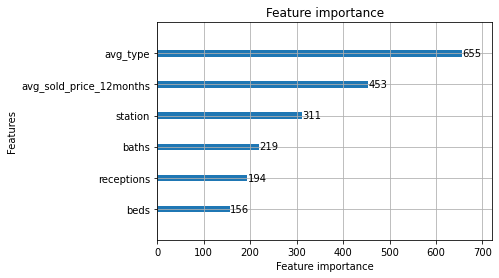

In [15]:
lgb.plot_importance(lgbm_reg)

In [16]:
final_X = X.copy()
final_X["pred"] = lgbm_reg.predict(final_X)
final = pd.concat([final_X, y], axis=1)
final["diff"] = round(abs(final["price"] - final["pred"]))
final["error"] = round(abs(((final["diff"]/final["price"])*100)))
final

,station,beds,baths,receptions,avg_sold_price_12months,avg_type,pred,price,diff,error
0,1.3,2,1.0,1.0,162788,101576.0,127197.156326,110000.0,17197.0,16.0
1,1.4,2,1.0,1.0,162788,101576.0,127197.156326,115000.0,12197.0,11.0
2,0.7,2,1.0,1.0,162788,101576.0,132775.917838,170000.0,37224.0,22.0
3,1.4,3,1.0,1.0,162788,208116.0,198984.601685,180000.0,18985.0,11.0
4,1.9,3,1.0,0.0,162788,208116.0,208121.969429,190000.0,18122.0,10.0
...,...,...,...,...,...,...,...,...,...,...
6134,4.1,4,0.0,0.0,272071,334295.0,488958.211192,600000.0,111042.0,19.0
6135,1.7,4,1.0,1.0,272071,334295.0,374362.937483,375000.0,637.0,0.0
6136,0.4,4,0.0,0.0,272071,334295.0,416591.265814,447500.0,30909.0,7.0
6137,1.4,5,0.0,0.0,272071,334295.0,511333.894931,350000.0,161334.0,46.0


In [17]:
import pickle
pickle.dump(lgbm_reg, open("lgbmmodel.pkl", "wb"))